In [1]:

import json

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from settings import BASE_DIR

/Users/akhil/code/ml_gallery/ml_py


In [2]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N)
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)

        out = self.gamma*out + x
        return out

In [3]:

def plot_img(image, landmarks=None, circles=None, circles2=None, landmarks2=None):
    """
    image: np.array of shape (c, h, w)
    landmarks: np.array of shape (n, 2)
    circles: np.array of shape (n, 3)
    """
    plt.imshow(np.moveaxis(np.array(image), 0, -1))

    _, h, w = image.shape

    if landmarks is not None and len(landmarks) > 0:
        x = landmarks[:, 0]
        y = landmarks[:, 1]
        plt.scatter(x, y)

    if circles is not None and len(circles) > 0:
        for circle in circles:
            xc, yc, r = circle
            plt.gca().add_patch(plt.Circle((xc, yc), r, fill=False))

    if landmarks2 is not None and len(landmarks2) > 0:
        x = landmarks2[:, 0]
        y = landmarks2[:, 1]
        plt.scatter(x, y, color='red')

    if circles2 is not None and len(circles2) > 0:
        for circle in circles2:
            xc, yc, r = circle
            plt.gca().add_patch(plt.Circle((xc, yc), r, color='red', fill=False))



In [4]:
transform = A.Compose (
    [
        A.Resize(height=300, width=400),
        # A.RandomSizedCrop(min_max_height=(250, 250), height=300, width=400, p=0.5),
        # A.CenterCrop(height=200, width=200),
        # A.ToGray(p=0.2),
        # A.ChannelDropout(channel_drop_range=(1, 2), p=0.2),
        # A.ChannelShuffle(p=0.2),
        # A.HueSaturationValue(p=0.2),
        # A.ImageCompression(quality_lower=60, p=0.1),
        # A.Posterize(p=0.2),
        # A.Rotate(limit=40, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        # A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

In [5]:
def normalize_inner_width(inner_widths: np.array):
    return inner_widths / (400 * 0.25)

def normalize_outer_width(widths: np.array):
    return widths / (400 * 0.50)

def denormalize_inner_width(inner_widths: np.array):
    return inner_widths * (400 * 0.25)

def denormalize_outer_width(widths: np.array):
    return widths * (400 * 0.50)

def normalize_center(center: np.array):
    # Find offset
    offset = center - np.array([300 / 2, 400 / 2])
    return offset / [300, 400]

def denormalize_center(center: np.array):
    center_ = torch.tensor([300 / 2, 400 / 2])
    return center_ + center * torch.tensor([300, 400])



In [6]:
class IrisImageDataset(Dataset):
    def __init__(self, images_dir, labels_path, transform=None):
        super(IrisImageDataset, self).__init__()
        self.data = []
        self.images_dir = images_dir
        self.labels_path = labels_path
        self.transform = transform
        self.height = 300
        self.width = 400

        with open(labels_path) as json_file:
            self.labels = json.load(json_file)

        self.image_names = sorted(list(self.labels.keys()))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        label = self.labels[image_name]
        image = Image.open(f'{self.images_dir}/{image_name}.tiff')
        image = np.array(image)

        inner_landmarks = label['inner']['landmarks']
        outer_landmarks = label['outer']['landmarks']
        inner_circle = label['inner'].get('circles')
        center = [[inner_circle['xc'], inner_circle['yc']]] if inner_circle else []

        landmarks = inner_landmarks + outer_landmarks + center

        if self.transform:
            augmentations = self.transform(image=image, keypoints=landmarks)
            image = augmentations['image']
            landmarks = augmentations['keypoints']

        n_inner = len(inner_landmarks)
        n_outer = len(outer_landmarks)

        inner = np.array(landmarks[:n_inner])
        outer = np.array(landmarks[n_inner: n_inner + n_outer])
        
        labels = {
            'inner': self.normalize_landmarks(inner).tolist(),
            'outer': self.normalize_landmarks(outer).tolist(),
            'center': normalize_center(np.array(landmarks[-1])),
            'inner_width': normalize_inner_width(self.get_width(inner)),
            'outer_width': normalize_outer_width(self.get_width(outer)),
            'name': image_name
        }

        # Covert from channels last to channels first
        image = np.moveaxis(image, -1, 0)

        return image, labels

    @staticmethod
    def get_width( landmarks: np.array) -> float:
            xs = landmarks[:, 0]
            width = float(np.max(xs) - np.min(xs))
            return width

    def normalize_landmarks(self, landmarks):
        return landmarks / [self.width, self.height]

class IrisWidthsDataset(IrisImageDataset):
    def __getitem__(self, index):
        image, labels = super().__getitem__(index)
        return image, (labels['inner_width'], labels['outer_width'], labels['center'][0], labels['center'][1])


In [7]:
data_dir = f'{BASE_DIR}/data/pupil'
images_dir = f'{data_dir}/train/images'
labels_path = f'{data_dir}/train/labels.json'

In [8]:
dataset = IrisWidthsDataset(images_dir=images_dir, labels_path=labels_path, transform=transform)

In [9]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)  #, collate_fn=lambda x: x)

In [17]:
class IrisDetector(nn.Module):
    def __init__(self):
        super(IrisDetector, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 8, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8, 8, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Conv2d(8, 16, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Conv2d(16, 32, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 38, 50

            nn.Conv2d(32, 64, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 19, 25

            SelfAttention(64),

            # nn.Conv2d(128, 256, padding=1, kernel_size=3),
            # nn.ReLU(),
            # nn.Conv2d(256, 256, padding=1, kernel_size=3, stride=2),
            # nn.ReLU(),
            # # 5, 7
            #
            # nn.Conv2d(256, 512, padding=1, kernel_size=3),
            # nn.ReLU(),
            # nn.Conv2d(512, 64, padding=1, kernel_size=3, stride=2),
            # nn.ReLU(),
            # # 3, 4

        )

        self.center = nn.Sequential(
            nn.Conv2d(64, 128, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 10, 13

            nn.Flatten(),

            nn.Linear(128 * 10 * 13, 512),
            nn.Tanh(),
            nn.Dropout(0.3),

            nn.Linear(512, 2),
            nn.Tanh(),
        )

        self.widths = nn.Sequential(
            nn.Conv2d(64, 128, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, padding=1, kernel_size=3, stride=2),
            nn.ReLU(),
            # 10, 13

            nn.Flatten(),

            nn.Linear(128 * 10 * 13, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 2)
        )

    def forward(self, x):
        features = self.features(x)
        center = self.center(features)



        widths = self.widths(features)
        return torch.cat((widths, center), 1)

model = IrisDetector()

In [18]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

0.145475372672081
  -0.029561713337898254 0.27000001072883606
  0.008375217206776142 0.03999999910593033
  -0.031885113567113876 -0.16500000655651093

3331853312.0
  -0.02825232595205307 0.20000000298023224
  0.10517410188913345 170590896128.0
  -0.15161703526973724 -255886344192.0

0.09260033816099167
  -0.025185871869325638 0.41999998688697815
  0.21904075145721436 -0.022285940125584602
  -0.22625252604484558 -0.2195434868335724

0.07671190053224564
  -0.023642554879188538 0.1899999976158142
  0.25191205739974976 0.09365151822566986
  -0.16131220757961273 -0.1573391854763031

0.06152679771184921
  -0.0308971144258976 0.3199999928474426
  0.222074493765831 0.16551470756530762
  -0.12255892902612686 -0.19493332505226135

0.06056902930140495
  -0.025103315711021423 0.23000000417232513
  0.17626920342445374 0.2133333384990692
  -0.10250027477741241 -0.05999999865889549

0.07175596058368683
  -0.02406119741499424 0.3799999952316284
  0.1414099484682083 0.27306050062179565
  -0.12904381752

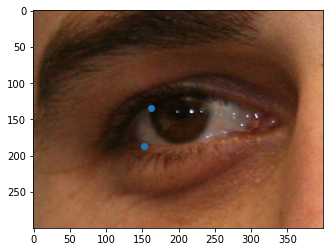

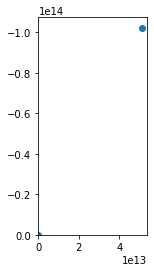

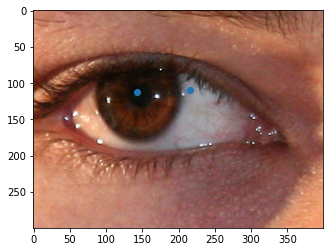

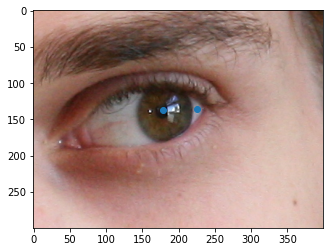

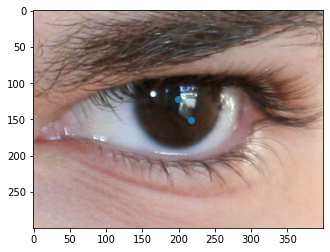

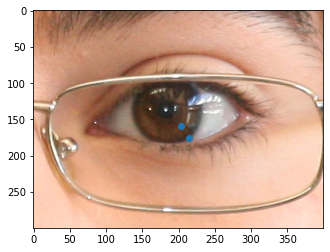

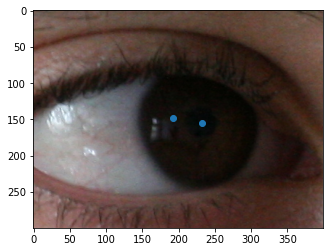

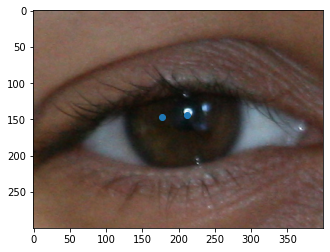

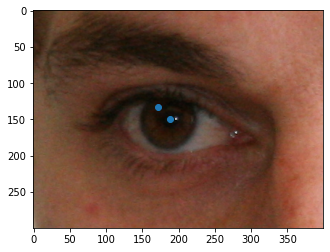

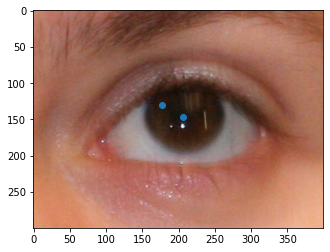

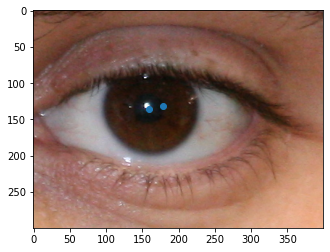

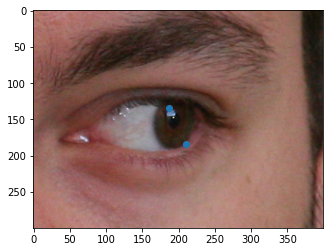

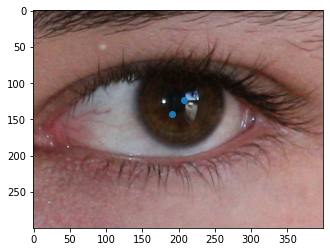

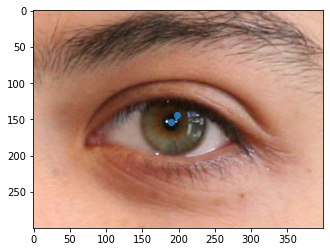

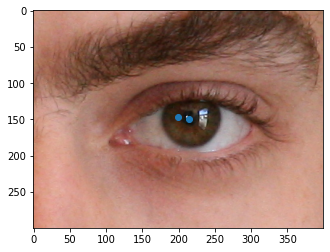

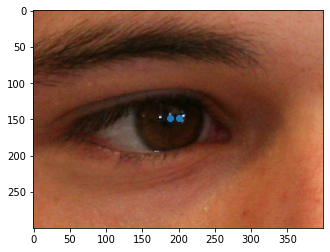

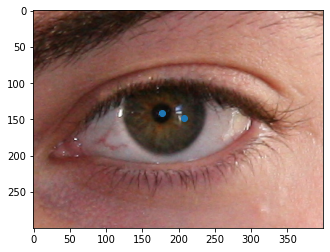

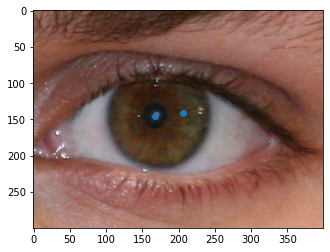

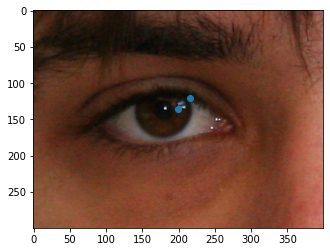

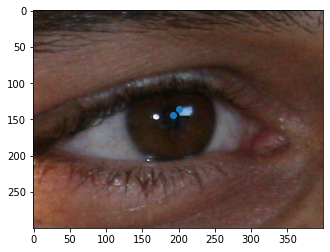

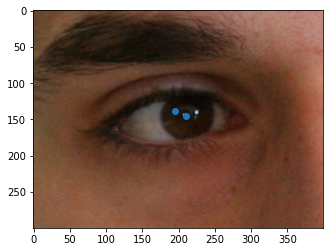

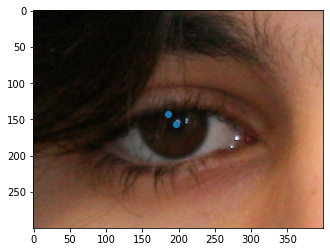

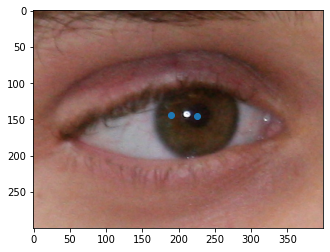

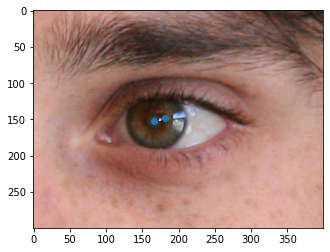

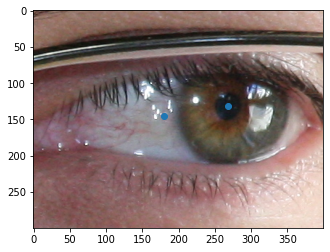

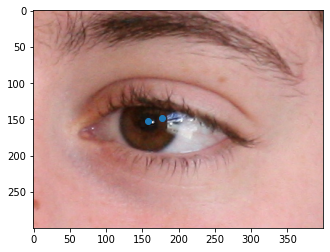

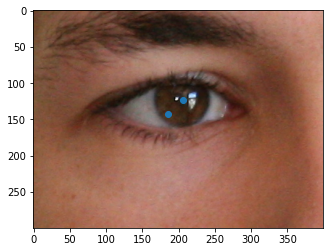

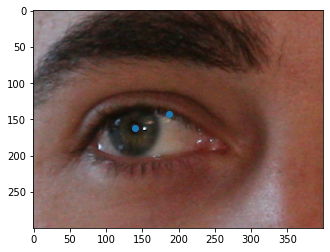

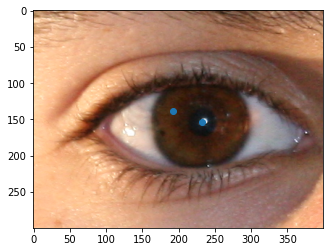

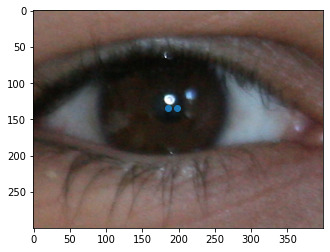

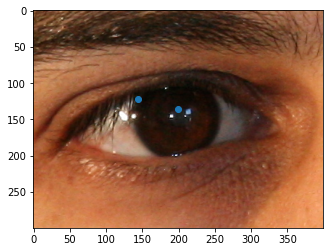

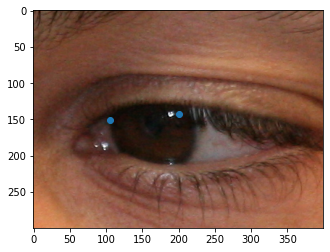

In [20]:
epochs = 1

for epoch in range(epochs):
    for images, labels in train_loader:
        labels = torch.stack(labels).T.float()
        yh = model(images.float())

        loss_c = F.l1_loss(yh[:, 2:], labels[:, 2:])
        # loss_c = F.mse_loss(yh[:, 2:], labels[:, 2:])

        loss_w = F.mse_loss(yh[:, :2], labels[:, :2])

        loss = loss_c + 0 * loss_w

        optim.zero_grad()
        loss.backward()
        optim.step()

        print(loss.item())
        print(' ', yh[0][0].item(), labels[0][0].item())
        centers_denorm_label = denormalize_center(labels[:, 2:])[0]
        centers_denorm_pred = denormalize_center(yh[:, 2:])[0].detach()
        print(' ', yh[0][2].item(), labels[0][2].item())
        print(' ', yh[0][3].item(), labels[0][3].item())
        print()
        centers_denorm = torch.stack((centers_denorm_pred, centers_denorm_label))
        plot_img(images[0], centers_denorm)
        plt.show()
